# Noise schedules

> Investigating the curvature of the noise schedules

Adapted from

- [https://youtu.be/PXiD7ZjOKhA?si=iJMR2Tg050CemrxU&t=4314](https://youtu.be/PXiD7ZjOKhA?si=iJMR2Tg050CemrxU&t=4314)

In [1]:
#| default_exp noise_sched

In [2]:
import math

import matplotlib.pyplot as plt
import torch

from slowai.ddpm import DDPM, fashion_unet, get_dls
from slowai.utils import show_images

In [3]:
plt.style.use("ggplot")

Normally, we have a noise schedule like this:

In [4]:
def diff(x, dt):
    return (x[1:] - x[:-1]) / dt

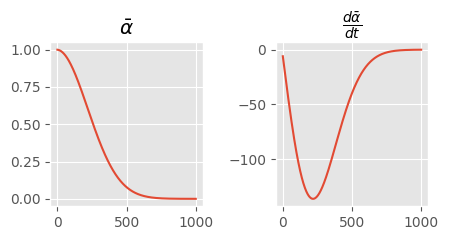

In [5]:
nsteps = 1000
dt = (0.02 - 0.0001) / nsteps
beta = torch.linspace(0.0001, 0.02, nsteps)
alpha = 1 - beta
ᾱ = alpha.cumprod(dim=0)
dᾱ_dt = diff(ᾱ, dt)
fig, (a0, a1) = plt.subplots(1, 2, figsize=(4.5, 2.5))
a0.set(title=r"$\bar{\alpha}$")
a0.plot(ᾱ)
a1.set(title=r"$\frac{d\bar{\alpha}}{dt}$")
a1.plot(dᾱ_dt)
fig.tight_layout()

There are a number of steps in this process where the change in noise is almost nothing. Compare this to a cosine schedule.

In [6]:
def ᾱ_cos(t, T):
    return (((t / T) * math.pi / 2).cos() ** 2).clamp(0.0, 0.999)

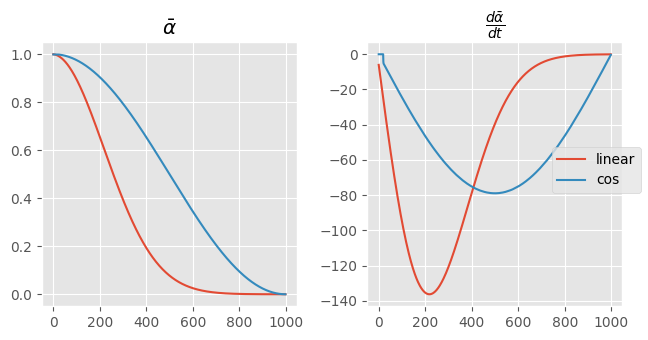

In [7]:
fig, (a0, a1) = plt.subplots(1, 2, figsize=(6.5, 3.5))
a0.set(title=r"$\bar{\alpha}$")
a1.set(title=r"$\frac{d\bar{\alpha}}{dt}$")

# Linear
a0.plot(ᾱ)
a1.plot(dᾱ_dt, label="linear")

# Cosine
x = ᾱ_cos(torch.linspace(0, nsteps - 1, nsteps), nsteps)
a0.plot(x)
a1.plot(diff(x, dt), label="cos")

fig.legend(loc="center right")
fig.tight_layout()

This is a more consistent noise scheduler, especially when considering the slope. Notice that tweaking `beta_max` actually makes the curvate more cosinusoidal.

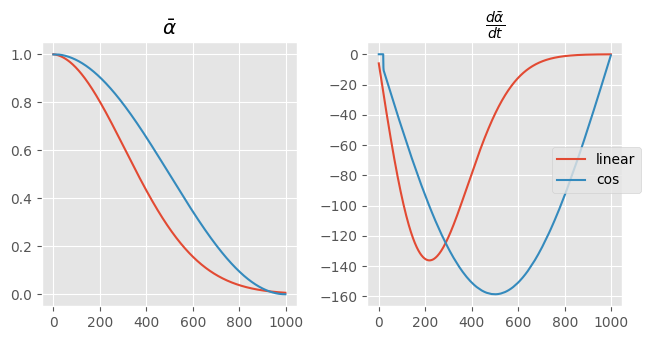

In [8]:
nsteps = 1000
dt = (0.01 - 0.0001) / nsteps
beta = torch.linspace(
    0.0001,
    0.01,  # 👈
    nsteps,
)
alpha = 1 - beta
ᾱ = alpha.cumprod(dim=0)

fig, (a0, a1) = plt.subplots(1, 2, figsize=(6.5, 3.5))
a0.set(title=r"$\bar{\alpha}$")
a1.set(title=r"$\frac{d\bar{\alpha}}{dt}$")

# Linear
a0.plot(ᾱ)
a1.plot(dᾱ_dt, label="linear")

# Cosine
x = ᾱ_cos(torch.linspace(0, nsteps - 1, nsteps), nsteps)
a0.plot(x)
a1.plot(diff(x, dt), label="cos")

fig.legend(loc="center right")
fig.tight_layout()

Even if we adopt a linear schedule, we'll clearly want to use a lower value of `beta_max` to spread out the noise addition over time. This was noticed by Robin Rombach, the author of Stable Diffusion, who noted that lower values of $\beta_{max}$ improved sampling.

If we were to train using this, we note that there are more examples that are clear.

In [9]:
def noisify(x0, ᾱ, n_steps=100):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt() * x0 + (1 - ᾱ_t).sqrt() * ε
    return (xt, t.to(device)), ε

In [10]:
dls = get_dls()
xb, _ = dls.peek()
(out, _), _ = noisify(xb, x)
out.shape

torch.Size([128, 1, 32, 32])

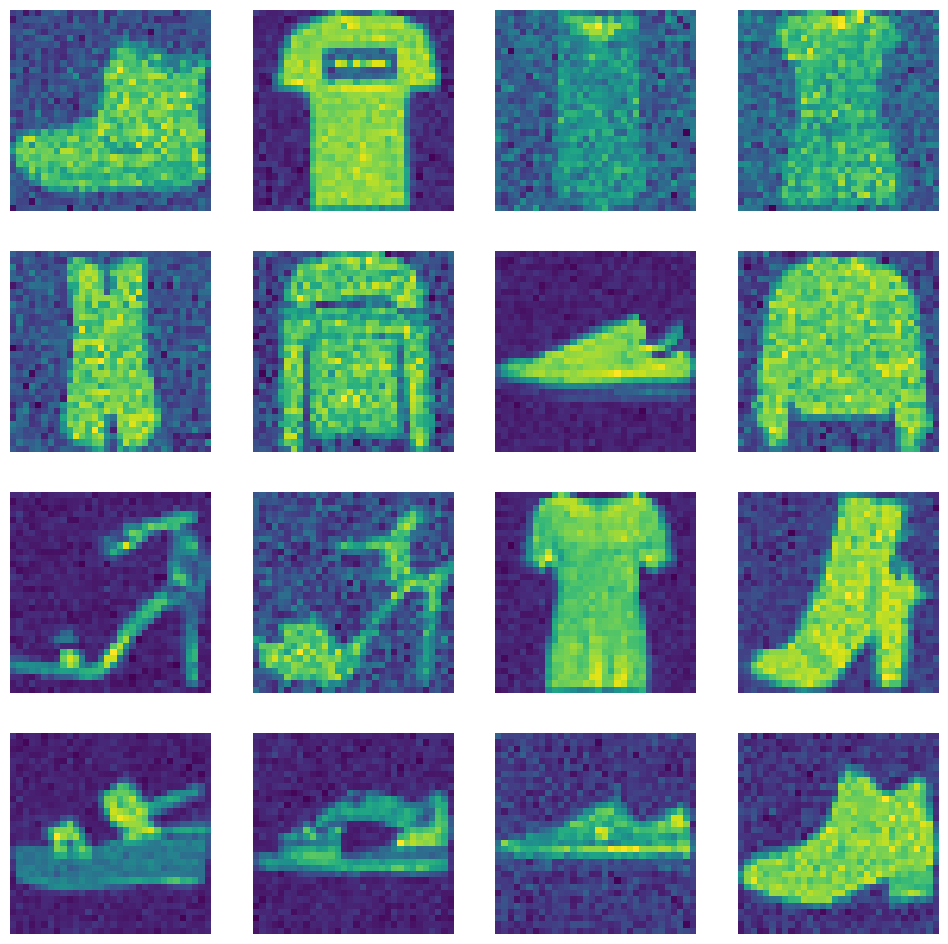

In [11]:
show_images(out[:16])

In [12]:
#| hide
import nbdev

nbdev.nbdev_export()